<div style="border:solid green 2px; padding: 20px">

<b>Привет, Дмитрий! Поздравляю с выполнением очередного проекта!</b>

Меня зовут Петр Раздобреев и я буду проверять твою работу. Попробую помочь сделать тебе её еще лучше! В Практикуме принято общени на ты, но если это дискомфортно, то сообщи об этом)

Ниже ты найдешь мои комментарии - пожалуйста, не перемещай, не изменяй и не удаляй их. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ Так выделены небольшие замечания.Такие замечания в проекте допустимы, это пространство для улучшений в будущем.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️Так я выделяю успешные идеи.</div>

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
    



<div class="alert alert-info"> <b>Комментарий студента:</b> Пётр, привет! Спасибо большое за обратную связь, постараюсь всё исправить!</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Здравствуй, Дмитрий, отличное рвение, рад, что мои комментарии порадовали)!
</div>


# Исследование рынка заведений общественного питания Москвы 

**Цель исследования** - провести исследовательский анализ рынка заведений общественного питания в Москве и подготовить презентацию для потенциальных инвесторов, которые смогут использовать её для оценки инвестиционной привлекательности открытия нового ресторана.

**Ход исследования**

Для проекта будут использованы открытые данные о заведениях общепита - адрес, количество посадочных мест, факт пренадлежности к какой-либо сети, а также тип предприятия по классификации заведений общественного питания в РФ <a href="https://docs.cntd.ru/document/1200107325">(**ГОСТ 30389-2013**)</a>. Данные будут предобработаны и проанализированы, а на основании сделаных выводов будет подготовлена презентация для инвесторов. Таким образом, исследование будет разбито на следующие этапы:

1. [**Обзор и предобработка данных**](#overview)
2. [**Исследовательский анализ данных**](#EDA)
3. [**Общий вывод и рекомендации**](#presentation)

<a id='overview'></a>

## Обзор и предобработка данных

Данные представлены в файле `rest_data.csv`.

Описание данных:

 * `id` — идентификатор объекта;
 * `object_name` — название объекта общественного питания;
 * `chain` — сетевой ресторан;
 * `object_type` — тип объекта общественного питания;
 * `address` — адрес;
 * `number` — количество посадочных мест.
 
Загрузим данные и выведем основную информацию о таблице:

In [2]:
cell_id_counter = 0
existing_cell_ids = set()

def get_cell_id(cell_id=None):
    """Return a new unique cell id

    if cell_id is given, use it if available (e.g. preserving cell id on paste, while ensuring no collisions)
    """
    global cell_id_counter

    if cell_id and cell_id not in existing_cell_ids:
        # requested cell id is available
        existing_cell_ids.add(cell_id)
        return cell_id

    # generate new unique id
    cell_id = str(cell_id_counter)
    while cell_id in existing_cell_ids:
       cell_id_counter += 1
       cell_id = f"id{cell_id_counter}"
    existing_cell_ids.add(cell_id)
    cell_id_counter += 1
    return cell_id

def free_cell_id(cell_id):
    """record that a cell id is no longer in use"""
    existing_cell_ids.remove(cell_id)

In [1]:
pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import re

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
np.set_printoptions(threshold=np.inf)
sns.set_style('whitegrid')
plt.rcParams.update({'axes.labelsize': 10,'axes.titlesize': 15})


# загружаем данные, выводим основную информацию и 5 случайных строк

data = pd.read_csv('/datasets/rest_data.csv')
data.info()
data.sample(5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, стро...",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300
6737,23349,Столовая ГБОУ СОШ № 1900,нет,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240
14940,222539,Holy Vegan,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
4088,26585,Ресторан «Очаг гурманов»,нет,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42


Таблица содержит 6 столбцов и 15,366 строк. Рассмотрим каждый столбец по отдельности c помощью функции:

In [3]:
original = data # на всякий случай сделаем переменную с сырым датасетом

# создадим список с названиями колонок
# аргументом функции будет являтся индекс этого списка

col = data.columns.tolist()


# функция "overview" выведет описательную статистику данных столбца.
# если есть пропуски - выведет их количество и процентную долю от общего числа значений

def overview(index):
    
    column = data[col[index]]
    na = column.isna().sum() # количество пропусков
    
    print(column.describe()) # описательная статистика
    print(f'data type - {column.dtypes}') # тип данных столбца
    
    if na > 1: # если есть пропуски:
        
        print()
        print(f'cells with missing data = {na}') # количества пропусков
        print(f'missing data share = {round(na/len(column)*100, 2)}%') # доля пропусков в %       
    else:
        print()
        print('no missing cells')

# опробуем функцию overview на первом столбце

try:
    overview(0) # столбец с названием заведения
    
except:
    print('Функция не сработала.') 

count    15,366.00
mean    119,720.07
std      73,036.13
min         838.00
25%      28,524.00
50%     144,974.50
75%     184,262.25
max     223,439.00
Name: id, dtype: float64
data type - int64

no missing cells


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Хорошая функция, понравилось, что проверил корректность её работы </div>


Этот столбец содержит уникальный идентификатор предприятия общественного питания. Числовой тип тут неуместен, потому сохраним данные как текст и проверим их уникальность:

In [4]:
data['id'] = data['id'].astype('string') # меняем тип данных
overview(0) # снова вызываем функцию

count      15366
unique     15366
top       159382
freq           1
Name: id, dtype: object
data type - string

no missing cells


Переходим к следующему столбцу:

In [5]:
overview(1) # столбец с названием заведения

count        15366
unique       10393
top       Столовая
freq           267
Name: object_name, dtype: object
data type - object

no missing cells


Посмотрим уникальные значения столбца:

In [6]:
data['object_name'].sort_values().unique() # выводим уникальные значения

array(['1-ЫЙ МОСКОВСКИЙ КАДЕТСКИЙ КОРПУС', '1-й МОК',
       '100 личная столовая', '100 личное кафе', '1001 ночь', '100лоФФка',
       '101 вкус', '13 RULES', '13 RULES KRAFT BEER', '13 Rules',
       '15 Kitchen+bar', '18 АВТОБУСНЫЙ ПАРК', '19bar Atmosphere',
       '1x bet', '2-Й АВТОБУСНЫЙ ПАРК', "23'00", '24 Градуса', '259',
       '3 Skovorodki', '3 правила', '33 пингвина', '37-37', '44 Чашма',
       '495', '5звезд Юг 52', '68. ПАУЗА', '69 Pints Бар', '69 pints',
       '7 Сендвичей', '7 злаков', '7 сэндвичей-Meating',
       '7717 LOUNGE (Кальянная)', '8 OZ Унций', '8-ОЙ ТРОЛЛЕЙБУСНЫЙ ПАРК',
       '9 АВТОБУСНЫЙ ПАРК', '9bar', 'ABC Coffee Roasters', 'ACCENTI',
       'ADRY', 'AGLOMERAT', 'AL33 Пиццерия Бар Ботега', 'ALOHA POKE BAR',
       'AMARSI', 'AMG', 'APARTAMENT Пар Бар', 'AQKitchen', 'ART PUB',
       'Abbey Players Irish Pub', 'Absolem', 'Acai Family',
       'Alex Пекарня', 'Amande Cafe', 'Americano Кафе', 'Amerigos Pizza',
       'Amore Grande', 'Amore, итальянское мо

In [7]:
data['object_name'].str.lower().value_counts()

столовая                           321
кафе                               278
шаурма                             250
шоколадница                        158
kfc                                155
                                  ... 
горыныч                              1
мидл ист                             1
coffee bo                            1
кафе здоровой еды «healty food»      1
амстердам                            1
Name: object_name, Length: 9924, dtype: int64

* Даже при поверхостном осмотре списка выше можно заметить множество неявных дубликатов, в основном обусловленных наличием опечаток или использованием разных регистров. В рамках исследования тщательная обработка названий заведений не оправдана - данных остальных столбцов будет достаточно для большинства необходимых выводов.

Для уменьшения количества дубликатов названия будут приведены к нижнему регистру - таким образом можно будет выделить самые крупные сети. Так как пропущенные значения отсутствуют, данные этого столбца также можно преобразовать в текст:

In [8]:
# меняем тип данных и регистр

data['object_name'] = (
    data['object_name']
    .str.lower()
    .astype('string')
) 

Переходим дальше:

In [9]:
overview(2) # пренадлежность к сети ресторанов

count     15366
unique        2
top         нет
freq      12398
Name: chain, dtype: object
data type - object

no missing cells


Для экономии памяти данные этого столбца можно преобразовать в тип `boolean`:

In [10]:
data['chain'] = data['chain'].replace({'да' : True, 'нет': False})

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 

А почему бы вывод уникальных значений не добавить в саму функцию первичного анализа?)
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо, комментарий справедливый. Изначально я написал эту функцию для одного из предыдущих проектов, где было больше 15 столбцов для обработки - там это действительно было просто необходимо, но для корректной работы нужна большая условная конструкция. Из серии, если тип данных == `object`, тогда выводим уникальные значения, если `int` или `float` - тогда строим график корреляции и т.д. Здесь мне показалось это лишним, функция и так довольно объёмная для такого количества столбцов, не хотелось чтобы она ещё разрослась. К тому же иногда нужен `unique`, иногда `value_counts`, решил что проще будет вручную. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Спасибо за аргументацию, принимается. Только может быть дилеммой порой усложнение функции против количества кода
</div>


Переходим дальше:

In [11]:
overview(3) # тип заведения

count     15366
unique        9
top        кафе
freq       6099
Name: object_type, dtype: object
data type - object

no missing cells


In [12]:
data['object_type'].unique() # проверим уникальность значений

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Для удобства визуализации данных сократим слишком длинные названия типов предприятий.  Для экономии памяти мы можем преобразовать данные в тип категорий:

In [13]:
# меняем тип данных, сокращаем длинные значения

data['object_type'] = (
    data['object_type']
    .replace({'предприятие быстрого обслуживания': 'фаст-фуд',
              'магазин (отдел кулинарии)':'кулинария'})
    .astype('category')

) 

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Отличная идея, теперь подписи к графикам компактнее </div>


Следующий столбец - один из ключевых для исследования:

In [14]:
overview(4) # адрес заведения

count                                      15366
unique                                      9108
top       город Москва, Ходынский бульвар, дом 4
freq                                          95
Name: address, dtype: object
data type - object

no missing cells


Сам по себе полный адрес не несёт большой пользы - слишком много уникальных значений, что сделает невозможным какую-либо категоризацию. Намного информативнее будет название улицы и округ/район, в котором находится ресторан.

In [15]:
# сначала попробуем разбить адрес на части

address_split = data['address'].str.split(',', expand=True)
address_split

,0,1,2,3,4,5,6
0,город Москва,улица Егора Абакумова,дом 9,None,None,None,None
1,город Москва,улица Талалихина,дом 2/1,корпус 1,None,None,None
2,город Москва,Абельмановская улица,дом 6,None,None,None,None
3,город Москва,Абрамцевская улица,дом 1,None,None,None,None
4,город Москва,Абрамцевская улица,дом 9,корпус 1,None,None,None
...,...,...,...,...,...,...,...
15361,город Москва,3-й Крутицкий переулок,дом 18,None,None,None,None
15362,город Москва,улица Земляной Вал,дом 33,None,None,None,None
15363,город Москва,улица Земляной Вал,дом 33,None,None,None,None
15364,город Москва,поселение Московский,Киевское шоссе,22-й километр,домовладение 4,строение 1,None


In [16]:
# посмотрим, все ли адреса начинаются одинаково

address_split[0].value_counts()

город Москва                     15295
улица Ленинская Слобода              4
Николоямская улица                   4
город Московский                     3
Солянский тупик                      3
улица Льва Толстого                  3
2-я Брестская улица                  2
Ленинградский проспект               2
Бауманская улица                     2
Таганская площадь                    2
Партизанская улица                   2
1-й Нагатинский проезд               1
Ленинский проспект                   1
Алтуфьевское шоссе                   1
город Троицк                         1
Митинская улица                      1
Полевая улица                        1
Калашный переулок                    1
Большая Бронная улица                1
1-я Тверская-Ямская улица            1
Тушинская улица                      1
поселение "Мосрентген"               1
Большая Серпуховская улица           1
улица Знаменка                       1
Школьная улица                       1
поселение Сосенское      

Абсолютное большинство адресов начинается с `город Москва` - для упрощения обработки значений мы добавим город во все остальные адреса:

In [17]:
# укажем город во всех адресах

data.loc[~(data['address'].str.startswith('город')), 'address'] = (
    'город Москва, ' + data.loc[~(data['address'].str.startswith('город')), 'address']
)

Теперь когда мы представляем, как выглядит типичный адрес заведения, попробуем использовать регулярное выражение для извлечения названия улицы из адреса:

In [18]:
# создаём список со всеми возможными наименованиями улиц

str_types = ['улица','переулок','шоссе',
             'проспект','площадь', 'проезд', 
             'микрорайон', 'территория','село',
             'аллея','бульвар','набережная',
             'тупик','линия','квартал', 'город', 
             'поселение', 'посёлок', 'просек', '-й километр']

# пишем регулярное выражение, опираясь на запятые адреса

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(str_types))

# извлекаем название улицы в новый столбец

data["street"] = data["address"].str.extract(str_pat, flags=re.I)

# смотрим на обновлённый датафрейм, проверяем пропуски

display(data.sample(15, random_state=1))

data.isna().sum()

,id,object_name,chain,object_type,address,number,street
2973,22736,луна,False,кафе,"город Москва, Михалковская улица, дом 38, стро...",40,Михалковская улица
2593,29065,столовая гбоу 45 гимназия имени л.и. мильграмма,False,столовая,"город Москва, улица Гримау, дом 8",300,улица Гримау
6737,23349,столовая гбоу сош № 1900,False,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240,Дубравная улица
14940,222539,holy vegan,False,кафе,"город Москва, Ходынский бульвар, дом 4",0,Ходынский бульвар
4088,26585,ресторан «очаг гурманов»,False,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42,Каширское шоссе
5910,28867,школа 775,False,буфет,"город Москва, Армавирская улица, дом 4",210,Армавирская улица
10541,187743,24 градуса,False,бар,"город Москва, Митинская улица, дом 36",4,Митинская улица
14563,217236,чайхана ош,False,ресторан,"город Москва, проспект Андропова, дом 36",49,проспект Андропова
10497,182718,abc coffee roasters,False,кафе,"город Москва, улица Покровка, дом 7/9-11, корп...",15,улица Покровка
7708,111069,кафе иль патио «il patio»,True,кафе,"город Москва, Каширское шоссе, дом 26",176,Каширское шоссе


id             0
object_name    0
chain          0
object_type    0
address        0
number         0
street         0
dtype: int64

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 

Зачем тогда было важно, чтобы город Москва были везде? 
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Если честно - у меня не получалось по-другому составить регулярное выражение. 🙈 В таком виде оно не воспринимает название улицы, если перед ним не стоит запятая, потому адреса без города Москва в начале не попадали в столбец. Я долго мучался, но так и не смог это исправить.
Хотелось попробовать что-то новое для этой задачи, но тема оказалась сложнее, чем я ожидал. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Ниже приложил вариант реализации) на первичном датафрейме, в котором не было правок) 
</div>


In [19]:

# Вот такой вариант у меня есть, попробовал, работает корректно
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

original["street_rev"] = original["address"].str.extract(str_pat, flags=re.I)
original.info()
original.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           15366 non-null  string  
 1   object_name  15366 non-null  string  
 2   chain        15366 non-null  bool    
 3   object_type  15366 non-null  category
 4   address      15366 non-null  object  
 5   number       15366 non-null  int64   
 6   street       15366 non-null  object  
 7   street_rev   14979 non-null  object  
dtypes: bool(1), category(1), int64(1), object(3), string(2)
memory usage: 750.8+ KB


,id,object_name,chain,object_type,address,number,street,street_rev
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Абельмановская улица
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,Абрамцевская улица
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,Абрамцевская улица


Получилось! Теперь обратимся к внешним источникам для определения района и административного округа:

In [20]:
# используем данные компании АО "Мосгаз"

district = (
    pd.read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv')
)

# смотрим на таблицу

district.info()
district.sample(15, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   streetname  4398 non-null   object
 1   areaid      4398 non-null   int64 
 2   okrug       4398 non-null   object
 3   area        4398 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB


,streetname,areaid,okrug,area
854,Суздальская улица,30,ВАО,Район Новокосино
1925,Малое кольцо Московской железной дороги (МКМЖД),56,САО,Бескудниковский Район
2330,Ленская улица,72,СВАО,Бабушкинский район
2040,Большая Академическая улица,62,САО,Район Коптево
1758,Ленинградское шоссе,52,Зеленоград,Район Матушкино-Савелки
453,2-й Тверской-Ямской переулок,19,ЦАО,Тверской район
4360,Малый Сергиевский переулок,16,ЦАО,Мещанский район
3654,3-я Фрунзенская улица,20,ЦАО,Район Хамовники
3854,проспект 60-летия Октября,123,ЮЗАО,Академический район
1060,15-я Парковая улица,24,ВАО,Район Восточное Измайлово


In [21]:
# проверим дубликаты

district[district['streetname'].duplicated()]

,streetname,areaid,okrug,area
312,площадь Варварские Ворота,19,ЦАО,Тверской район
321,улица Гашека,19,ЦАО,Тверской район
323,Большая Никитская улица,19,ЦАО,Тверской район
324,Большой Гнездниковский переулок,19,ЦАО,Тверской район
325,Малый Гнездниковский переулок,19,ЦАО,Тверской район
...,...,...,...,...
4385,Благовещенский переулок,17,ЦАО,Пресненский район
4388,2-я Брестская улица,17,ЦАО,Пресненский район
4389,Большая Бронная улица,17,ЦАО,Пресненский район
4392,Васильевская улица,17,ЦАО,Пресненский район


In [22]:
# посмотрим на данные одной из задублированных улиц

district[district['streetname'] == 'улица Гашека']

,streetname,areaid,okrug,area
1,улица Гашека,17,ЦАО,Пресненский район
321,улица Гашека,19,ЦАО,Тверской район


* Согласно <a href="https://ru.wikipedia.org/wiki/%D0%A3%D0%BB%D0%B8%D1%86%D0%B0_%D0%93%D0%B0%D1%88%D0%B5%D0%BA%D0%B0_(%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0)">статье на Википедии</a>, эта улица действительно находится одновременно в двух разных районах Москвы. Это довольно характерный случай для Москвы, потому вероятнее всего это причина всех дубликатов. Для дальнешей работы с данными все названия улиц должны быть уникальными, потому при формировании выводов необходимо будет сделать поправку на точность распределения заведений по районам:

In [23]:
# удаляем дубликаты

district = district.drop_duplicates(subset=['streetname'])

# объединяем таблицы, удаляем лишние столбцы

data = (
    data
    .merge(district
           .rename(columns={'okrug':'area','area':'district'}), 
           left_on='street', 
           right_on='streetname', 
           how='left')
    .drop(['streetname', 'areaid'], axis=1)
)

In [24]:
# смотрим на обновлённую таблицу

data.info()
data.sample(15, random_state=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           15366 non-null  string  
 1   object_name  15366 non-null  string  
 2   chain        15366 non-null  bool    
 3   object_type  15366 non-null  category
 4   address      15366 non-null  object  
 5   number       15366 non-null  int64   
 6   street       15366 non-null  object  
 7   street_rev   14979 non-null  object  
 8   area         14677 non-null  object  
 9   district     14677 non-null  object  
dtypes: bool(1), category(1), int64(1), object(5), string(2)
memory usage: 1.1+ MB


,id,object_name,chain,object_type,address,number,street,street_rev,area,district
2973,22736,луна,False,кафе,"город Москва, Михалковская улица, дом 38, стро...",40,Михалковская улица,Михалковская улица,САО,Головинский район
2593,29065,столовая гбоу 45 гимназия имени л.и. мильграмма,False,столовая,"город Москва, улица Гримау, дом 8",300,улица Гримау,улица Гримау,ЮЗАО,Академический район
6737,23349,столовая гбоу сош № 1900,False,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240,Дубравная улица,Дубравная улица,СЗАО,Район Митино
14940,222539,holy vegan,False,кафе,"город Москва, Ходынский бульвар, дом 4",0,Ходынский бульвар,Ходынский бульвар,САО,Хорошевский район
4088,26585,ресторан «очаг гурманов»,False,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42,Каширское шоссе,Каширское шоссе,ЮАО,Район Москворечье-Сабурово
5910,28867,школа 775,False,буфет,"город Москва, Армавирская улица, дом 4",210,Армавирская улица,Армавирская улица,ЮВАО,Район Люблино
10541,187743,24 градуса,False,бар,"город Москва, Митинская улица, дом 36",4,Митинская улица,Митинская улица,СЗАО,Район Митино
14563,217236,чайхана ош,False,ресторан,"город Москва, проспект Андропова, дом 36",49,проспект Андропова,проспект Андропова,ЮАО,Даниловский район
10497,182718,abc coffee roasters,False,кафе,"город Москва, улица Покровка, дом 7/9-11, корп...",15,улица Покровка,улица Покровка,ЦАО,Басманный район
7708,111069,кафе иль патио «il patio»,True,кафе,"город Москва, Каширское шоссе, дом 26",176,Каширское шоссе,Каширское шоссе,ЮАО,Район Москворечье-Сабурово


<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 
    
При использовании `sample` лучше фиксировать параметр `random_state`, так гарантируется, что и ты и заказчик увидите одни и теже данные)
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо, я не знал про такую штуку. 🙈 Добавил везде. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Рад, что удалось подкачать твою аналитическую мышцу) 
</div>


Проверим пропущенные значения:

In [25]:
na = data.isna().sum()

print('missing value count')
print()
print(na)

missing value count

id               0
object_name      0
chain            0
object_type      0
address          0
number           0
street           0
street_rev     387
area           689
district       689
dtype: int64


In [26]:
# расчитаем долю пропусков
print(f'missing value share is {round(na.sum()/2/len(data)*100, 2)}%')

missing value share is 5.74%


Видимо при объединении таблиц не все адреса совпали. Так как доля пропусков составляет меньше 5%, мы можем удалить эти данные без значительного влияния на результаты исследования:

In [27]:
data = (
    data
    .dropna()
    .reset_index(drop=True)
)
data

,id,object_name,chain,object_type,address,number,street,street_rev,area,district
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова,СВАО,Ярославский Район
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,ЦАО,Таганский район
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Абельмановская улица,ЦАО,Таганский район
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,Абрамцевская улица,СВАО,Район Лианозово
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,Абрамцевская улица,СВАО,Район Лианозово
...,...,...,...,...,...,...,...,...,...,...
14502,219759,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова,улица Вавилова,ЮАО,Донской район
14503,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,3-й Крутицкий переулок,ЦАО,Таганский район
14504,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,улица Земляной Вал,ЦАО,Таганский район
14505,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,улица Земляной Вал,ЦАО,Таганский район


Обновлённая таблица теперь содержит название улицы и наименование административного округа и района, что послужит основой для категоризации во время исследовательского анализа данных. Преобразуем данные адреса в текст,  обновим список названий колонок и и перейдём к следующему столбцу:

In [28]:
# меняем тип данных

data['address'] = data['address'].astype('string')

col = data.columns.tolist()

In [29]:
overview(5) # вместимость заведения

count   14,507.00
mean        60.22
std         75.19
min          0.00
25%         14.00
50%         40.00
75%         80.00
max      1,700.00
Name: number, dtype: float64
data type - int64

no missing cells


<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 

А всё же почему не по названиям анализ столбцов датафрейма? Номера проще вбивать, но они менее информативны</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Как написал в предыдущем комментарии - изначально функция создавалась для работы с датасетами с большим количеством столбцов. Мне кажется так удобнее, ведь с названиями часто приходится возвращаться к описанию данных или снова выводить таблицу, чтобы вспомнить что было дальше. Я обязательно подписываю, что за данные мы рассматриваем, к тому же название отражается в 'describe'. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Да, подпись названия каждого столбца я видел 
</div>


Максимальная вместимость составляет 1,700 человек. Учитывая такой разброс значений, данные можно сократить до `int16` для экономии памяти.

In [30]:
# меняем тип данных

data['number'] = data['number'].astype('int16') 

# переименуем столбец, для большей информативности

data = data.rename(columns={'number':'capacity'}) 

Разделим заведения на категории в зависимости от вместимости, используя квартили - в зависимости от категории заведения можно будет охарактеризовать в дальнейшем исследовании: 

In [31]:
# функция для расчёта перцентеля

def cap_perc(val):
    perc = np.percentile(data['capacity'], val)
    return perc
    
# функция для определения категории вместимости    
    
def cap_category(val):
    if val <= cap_perc(25):
        return 'small'
    if val <= cap_perc(50):
        return 'medium'
    if val <= cap_perc(75):
        return 'big'
    else:
        return 'large'
    
data['cap_category'] = data['capacity'].apply(cap_category).astype('category')
data

,id,object_name,chain,object_type,address,capacity,street,street_rev,area,district,cap_category
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова,СВАО,Ярославский Район,big
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,ЦАО,Таганский район,medium
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Абельмановская улица,ЦАО,Таганский район,large
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,Абрамцевская улица,СВАО,Район Лианозово,medium
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,Абрамцевская улица,СВАО,Район Лианозово,big
...,...,...,...,...,...,...,...,...,...,...,...
14502,219759,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова,улица Вавилова,ЮАО,Донской район,medium
14503,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,3-й Крутицкий переулок,ЦАО,Таганский район,big
14504,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,улица Земляной Вал,ЦАО,Таганский район,small
14505,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,улица Земляной Вал,ЦАО,Таганский район,medium


Переходим дальше:

In [32]:
overview(6) # название улицы

count             14507
unique             1801
top       проспект Мира
freq                204
Name: street, dtype: object
data type - object

no missing cells


Здесь также можно представить данные в виде текста:

In [33]:
data['street'] = data['street'].astype('string') # меняем тип данных

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 

В `pandas` `object` - это и есть строковый формат 
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Я сам буквально на днях узнал, что в pandas теперь есть возможность сохранять полностью текстовые столбцы как 'string' из статьи ниже. На данный момент разницы в скорости обработки или используемой памяти нет, но это может потенциально изменится в будущем, потому решил взять в привычку.

https://towardsdatascience.com/why-we-need-to-use-pandas-new-string-dtype-instead-of-object-for-textual-data-6fd419842e24
    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Спасибо за ссылку)
</div>


In [34]:
overview(7) # административный округ

count             14507
unique             1801
top       проспект Мира
freq                204
Name: street_rev, dtype: object
data type - object

no missing cells


Проверим уникальные значения:

In [35]:
data['area'].value_counts()

ЦАО           4437
ЮАО           1970
ЗАО           1422
САО           1347
СВАО          1346
ВАО           1282
ЮЗАО           925
ЮВАО           837
СЗАО           729
Зеленоград     212
Name: area, dtype: int64

* ЦАО с большим отрывом лидирует по количеству заведений

Эти данные можно представить в виде категорий:

In [36]:
data['area'] = data['area'].astype('string')

In [37]:
overview(8) # название района

count     14507
unique       10
top         ЦАО
freq       4437
Name: area, dtype: object
data type - string

no missing cells


Проверим уникальные значения:

In [38]:
data['district'].unique()

array(['Ярославский Район', 'Таганский район', 'Район Лианозово',
       'Район Арбат', 'Район Лефортово', 'Район Солнцево', 'Район Зюзино',
       'Район Коптево', 'Район Гольяново', 'Алтуфьевский район',
       'Район Свиблово', 'Бабушкинский район', 'Дмитровский район',
       'Даниловский район', 'Район Фили-Давыдково',
       'Красносельский район', 'Район Южное Тушино', 'Район Сокольники',
       'Академический район', 'Район Царицыно',
       'Район Чертаново Северное', 'Район Аэропорт',
       'Район Филевский Парк', 'Басманный район', 'Район Замоскворечье',
       'Савеловский район', 'Район Беговой', 'Район Хорошево-Мневники',
       'Район Люблино', 'Район Дорогомилово', 'Бескудниковский Район',
       'Район Отрадное', 'Район Щукино', 'Район Богородское',
       'Нагорный район', 'Район Северное Бутово', 'Район Марфино',
       'Останкинский район', 'Тверской район', 'Пресненский район',
       'Район Ростокино', 'Район Соколиная Гора',
       'Район Бирюлево Западное', 'Ра

Дубликатов нет, данные выглядят хорошо. Осталось только поменять тип данных:

In [39]:
data['district'] = data['district'].astype('string')

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️

При наличии столбца с уникальными идентификаторами лучше искать дубликаты во всех столбцах кроме него. Поэтому рекомендую исключить столбец `id` из рассмотрения и проверить ещё раз датафрейм на дубликаты.

</div>


<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо, я даже не подумал об этом. Добавил проверку сразу после этого комментария.</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
При поиске дубликатов лучше исключать столбец с подстрокой `id` в названии чтобы как раз вероятнее находить дубликаты 
</div>


Последний шаг - проверим датасет на дубликаты, исключив столбец с уникальными идентификаторами:

In [40]:
cols = data.columns.to_list()

data[data.duplicated(subset=cols[1:])]

,id,object_name,chain,object_type,address,capacity,street,street_rev,area,district,cap_category
2310,28611,комбинат питания мгту им.н.э.баумана,False,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100,2-я Бауманская улица,2-я Бауманская улица,ЦАО,Басманный район,large
3300,71896,буфет «коникс-школьник»,False,буфет,"город Москва, улица Удальцова, дом 21",100,улица Удальцова,улица Удальцова,ЗАО,Район Проспект Вернадского,large
3376,20914,буфет мади,False,буфет,"город Москва, Ленинградский проспект, дом 64",40,Ленинградский проспект,Ленинградский проспект,САО,Район Аэропорт,medium
4318,23759,столовая гбоу города москвы № 384,False,буфет,"город Москва, Беловежская улица, дом 67",100,Беловежская улица,Беловежская улица,ЗАО,Можайский Район,large
4424,23391,столовая «комбинат питания космос»,False,столовая,"город Москва, Новозаводская улица, дом 12/11",15,Новозаводская улица,Новозаводская улица,ЗАО,Район Филевский Парк,medium
...,...,...,...,...,...,...,...,...,...,...,...
13808,222932,старый баку,False,кафе,"город Москва, Кировоградская улица, владение 15А",120,Кировоградская улица,Кировоградская улица,ЮАО,Район Чертаново Центральное,large
13826,204947,буфет при кинотеатре,False,буфет,"город Москва, Ореховый бульвар, дом 22А",0,Ореховый бульвар,Ореховый бульвар,ЮАО,Район Орехово-Борисово Южное,small
14045,219518,sushi-make,False,фаст-фуд,"город Москва, Ярцевская улица, дом 19",0,Ярцевская улица,Ярцевская улица,ЗАО,Район Кунцево,small
14326,218542,кофе с собой,True,фаст-фуд,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0,Алтуфьевское шоссе,Алтуфьевское шоссе,СВАО,Алтуфьевский район,small


Нашлась 81 задублированная строка - их удаление не повлияет на результаты исследования, потому целесообразнее будет избавиться от них:

In [41]:
data = data.drop_duplicates(subset=cols[1:])

### Итоги

В начале предобработки данных сырой датасет был сохранён в переменную `original`. Сравним первоначальные и измененные в ходе обработки данные:

In [42]:
original

,id,object_name,chain,object_type,address,number,street,street_rev
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Абельмановская улица
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,Абрамцевская улица
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,Абрамцевская улица
...,...,...,...,...,...,...,...,...
15361,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,3-й Крутицкий переулок
15362,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,улица Земляной Вал
15363,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,улица Земляной Вал
15364,221900,шоколадница,True,кафе,"город Москва, поселение Московский, Киевское ш...",36,22-й километр,Киевское шоссе


In [43]:
data

,id,object_name,chain,object_type,address,capacity,street,street_rev,area,district,cap_category
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова,СВАО,Ярославский Район,big
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,ЦАО,Таганский район,medium
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Абельмановская улица,ЦАО,Таганский район,large
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,Абрамцевская улица,СВАО,Район Лианозово,medium
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,Абрамцевская улица,СВАО,Район Лианозово,big
...,...,...,...,...,...,...,...,...,...,...,...
14502,219759,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова,улица Вавилова,ЮАО,Донской район,medium
14503,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,3-й Крутицкий переулок,ЦАО,Таганский район,big
14504,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,улица Земляной Вал,ЦАО,Таганский район,small
14505,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,улица Земляной Вал,ЦАО,Таганский район,medium


In [44]:
# посчитаем разницу в количестве строк и используемых ресурсов памяти

size_diff = round((len(original)-len(data))/len(original)*100, 2)
memory_diff = round((3.7-3)/3*100, 2)


print(f'В ходе предобработки данных было удалено {size_diff}% датасета,\n '
      f'при этом удалось сократить использование памяти на {memory_diff}%.')

print()
data.info()
data.sample(10, random_state=1)

В ходе предобработки данных было удалено 6.12% датасета,
 при этом удалось сократить использование памяти на 23.33%.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14426 entries, 0 to 14506
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            14426 non-null  string  
 1   object_name   14426 non-null  string  
 2   chain         14426 non-null  bool    
 3   object_type   14426 non-null  category
 4   address       14426 non-null  string  
 5   capacity      14426 non-null  int16   
 6   street        14426 non-null  string  
 7   street_rev    14426 non-null  object  
 8   area          14426 non-null  string  
 9   district      14426 non-null  string  
 10  cap_category  14426 non-null  category
dtypes: bool(1), category(2), int16(1), object(1), string(6)
memory usage: 972.6+ KB


,id,object_name,chain,object_type,address,capacity,street,street_rev,area,district,cap_category
4981,27946,столовая при вниижт,False,столовая,"город Москва, 3-я Мытищинская улица, дом 10, с...",100,3-я Мытищинская улица,3-я Мытищинская улица,СВАО,Алексеевский район,large
897,24327,хинкальная 777,False,кафе,"город Москва, Большая Пироговская улица, дом 53",40,Большая Пироговская улица,Большая Пироговская улица,ЦАО,Район Хамовники,medium
10328,185546,шаурма,False,закусочная,"город Москва, Хорошёвское шоссе, дом 68",0,Хорошёвское шоссе,Хорошёвское шоссе,САО,Хорошевский район,small
7995,20905,московская экспертно импортная компания,False,столовая,"город Москва, Новая Басманная улица, дом 16, с...",25,Новая Басманная улица,Новая Басманная улица,ЦАО,Басманный район,medium
8130,125274,варвара,False,кафе,"город Москва, улица Петровка, дом 23/10, строе...",46,улица Петровка,улица Петровка,ЦАО,Тверской район,big
1537,21711,егоза,False,кафе,"город Москва, бульвар Дмитрия Донского, дом 16",40,бульвар Дмитрия Донского,бульвар Дмитрия Донского,ЮЗАО,Район Северное Бутово,medium
5614,28334,вельен,False,столовая,"город Москва, Южнопортовая улица, дом 24, стро...",34,Южнопортовая улица,Южнопортовая улица,ЮВАО,Южнопортовый Район,medium
2128,83993,столовая,False,столовая,"город Москва, улица Стромынка, дом 20",100,улица Стромынка,улица Стромынка,ВАО,Район Сокольники,large
1154,139386,паб гастро моментс,False,бар,"город Москва, Татарская улица, дом 7, строение 1",18,Татарская улица,Татарская улица,ЦАО,Район Замоскворечье,medium
1398,24436,kfc,True,фаст-фуд,"город Москва, Ярославское шоссе, дом 114",80,Ярославское шоссе,Ярославское шоссе,СВАО,Ярославский Район,big


При обработке удалось сохранить большую часть данных, а за счёт изменения типа данных - значительно сократить используемые ресурсы памяти, несмотря на присоединение нескольких столбцов другой таблицы
_______
**Что было отмечено при работе с данными:**

* Названия предприятий содержат множество неявных дубликатов, в основном обусловленных наличием опечаток или использованием разных регистров. В рамках исследования обработка названий заведений не оправдана - данных остальных столбцов будет достаточно для необходимых выводов.


* Некоторые улицы относятся одновременно к двум разным районам Москвы. В рамках исследования соотносить улицу с двумя районами технически невозможно, потому для каждой из них в случайном порядке был оставлен лишь одна локация - при формировании выводов необходимо будет сделать поправку на точность распределения заведений по районам.


* Округ ЦАО с большим отрывом лидирует по количеству заведений

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
* Промежуточных выводов переменных можно оставлять в финальной версии проекта меньше, чтобы не перегружать проект, проверять себя - отлично, но размер проекта существенно увеличивается 
* Некоторые улицы и ещё длиннее, можно было бы в отдельном датафрейме оставить соотношение улица - район, чтобы не дублировать строки датафрейма

* Обзор и предобработка получились довольно массивными, можно было бы добавить `markdown` заголовков для упрощения навигации и разделения проекта </div>


<a id='EDA'></a>

## Исследовательский анализ данных
В ходе анализа будут выполнены следующие шаги:

1. [**Исследования соотношения количества объектов общественного питания**](#EDA1)
2. [**Исследование соотношения количества посадочных мест в заведениях**](#EDA2)
3. [**Исследование распределения заведений по локациям**](#EDA3)

<a id='EDA1'></a>

### Исследования соотношения количества объектов общественного питания
Количество заведений будет рассмотрено в разрезе видов предприятий и отношения к какой-либо сети. Для начала сгруппируем данные:

In [45]:
# сделаем копию датасета для исследовательского анализа

eda = data

# группируем данные

df = (
    eda
    .pivot_table(index='object_type', 
                 values='id',
                 aggfunc='count'
                )
    .rename(columns={'id':'object_count'})
    .sort_values('object_count', ascending=False)
    .reset_index()
)

# для визуализации долей возьмём пять самых крупных видов заведений

eda_top_5 = (
    df[:5]
    .append({'object_type':'другие', 'object_count': (df[5:]['object_count'].sum())},
           ignore_index=True)
)

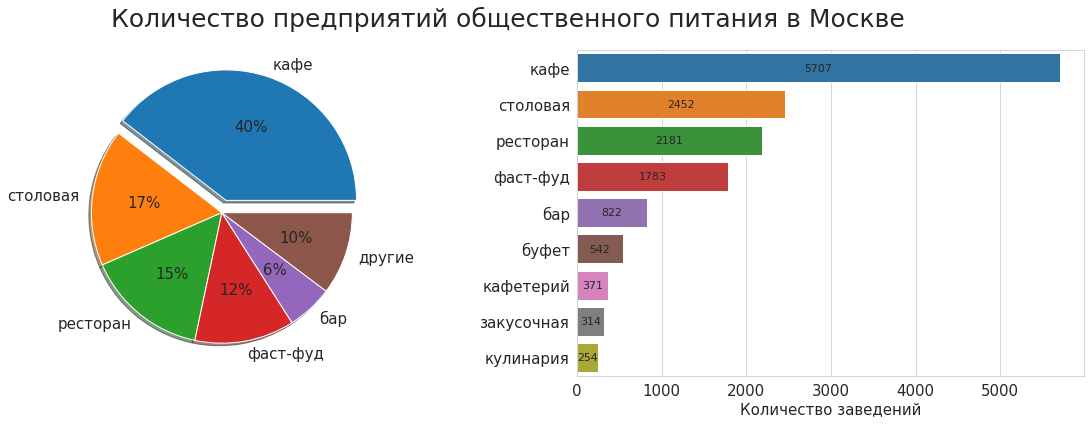

In [46]:
# строим график соотношения

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

labels = df['object_type'].to_list()
sns.barplot(data=df, y='object_type', 
            x='object_count', order=labels, ax=ax2)

ax1.pie(eda_top_5['object_count'], 
        labels=eda_top_5['object_type'],
        autopct='%.0f%%', textprops={'fontsize':15},
        explode=[0.1, 0, 0, 0, 0, 0],
        shadow=True
       )

ax2.tick_params(labelsize=15)
ax2.set_ylabel('')
ax2.set_xlabel('Количество заведений', size=15)
ax2.bar_label(ax2.containers[0], size=11, label_type='center')

fig.suptitle('Количество предприятий общественного питания в Москве', size=25)

plt.show()

- Доля кафе составляет 40% от всех заведений. Вместе со столовыми, ресторанами, предприятиями быстрого питания и барами они составляют 90% всех предприятий Москвы.

Для дальнейшего исследования остальные виды предприятий рассматривать нецелесообразно - объединим их в отдельную категорию `другие`. 

Следующий шаг - исследование соотношения сетевых и несетевых предприятий.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Соглашусь, хорошее решение </div>


In [47]:
# группируем данные

# таблица с сетевыми предприятиями

chains = (
    eda[eda['chain'] == True]
    .pivot_table(index='object_type', 
                 values='id',
                 aggfunc='count'
                )
    .rename(columns={'id':'object_count'})
    .sort_values('object_count', ascending=False)
    .reset_index()
)

# общее соотношение

ch_ratio = (
    eda
    .pivot_table(index='chain', 
                 values='id', 
                 aggfunc='count')
    .sort_values(['id'])
)

# добавляем количество сетевых заведений в общий датафрейм

df = (
    df
    .merge(chains, on='object_type', how='left')
    .rename(columns={'object_count_x':'total_objects', 
                     'object_count_y':'chain_objects'})
    
)

# оставляем топ-5 видов заведений, остальные объединяем

df = (
    df[:5]
    .append({'object_type':'другие', 
             'total_objects': (df[5:]['total_objects'].sum()),
             'chain_objects': (df[5:]['chain_objects'].sum())},
           ignore_index=True)
)

# считаем долю сетевых предприятий

df['chain_ratio'] = (
    round(df['chain_objects']/df['total_objects']*100, 2)
)

# смотрим на результат

df

,object_type,total_objects,chain_objects,chain_ratio
0,кафе,5707,1345,23.57
1,столовая,2452,3,0.12
2,ресторан,2181,513,23.52
3,фаст-фуд,1783,735,41.22
4,бар,822,36,4.38
5,другие,1481,193,13.03


- Значительная доля сетевых заведений наблюдается только у кафе, ресторанов и преприятий быстрого питания.

Визуализируем соотношений сетевых и несетевых заведений по количеству:

In [48]:
# напишем функцию для вывода топа заведений по заданному параметру

def top(val, par):    
    top = (
        df.sort_values(par, ascending=False)[:val]
          .append({'object_type':'другие', 
                   par: (df.sort_values(par, ascending=False)[val:][par].sum())},
               ignore_index=True)
    )
    return top[['object_type', par]]

# сделаем топ-3 вида заведений по количеству сетевых

top(3, 'chain_ratio')

,object_type,chain_ratio
0,фаст-фуд,41.22
1,кафе,23.57
2,ресторан,23.52
3,другие,17.53


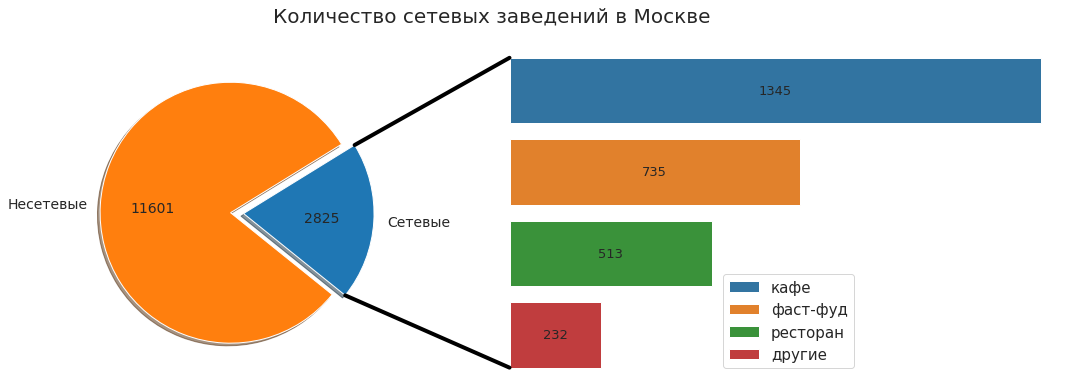

In [49]:
# строим график

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(wspace=0)

# круговая диаграмма

angle = -180 * (ch_ratio['id'].sum()/ch_ratio['id'][0]-1) + 5
values = lambda p: '{:.0f}'.format(p * ch_ratio['id'].sum() / 100)
wedges, *_ = ax1.pie(ch_ratio['id'], autopct=values, #autopct='%1.1f%%', 
                     startangle=angle, shadow=True, textprops={'fontsize': 14},
                     labels=['Сетевые', 'Несетевые'], explode=[0.1, 0])

# линейчатая диаграмма

top_3 = top(3, 'chain_objects')

sns.barplot(data=top_3, y='object_type',
            x='chain_objects', hue='object_type', 
            ax=ax2, dodge=False
           )
for i in range(len(top_3)):
    ax2.bar_label(ax2.containers[i], size=13, label_type='center')

    
# соединяем графики

theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = 1
bottom = 1
width = .2

# функция для линий, соединяющей графики

def connect(par_1, theta):

    x = r * np.cos(np.pi / 180 * theta) + center[0]
    y = r * np.sin(np.pi / 180 * theta) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, par_1), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(4)
    ax2.add_artist(con)


connect(-.4, theta2) # верхняя линия
connect(3.4, theta1) # нижняя линия

ax2.axis('off')
fig.suptitle('Количество сетевых заведений в Москве', size=20, va='top')

plt.legend(loc='lower center', prop={'size': 15})

plt.show()

- Кафе, рестораны и преприятия быстрого питания составляют около 90% всех сетевых заведений.

Визуализируем долю сетевых предприятий внутри этих видов заведений:

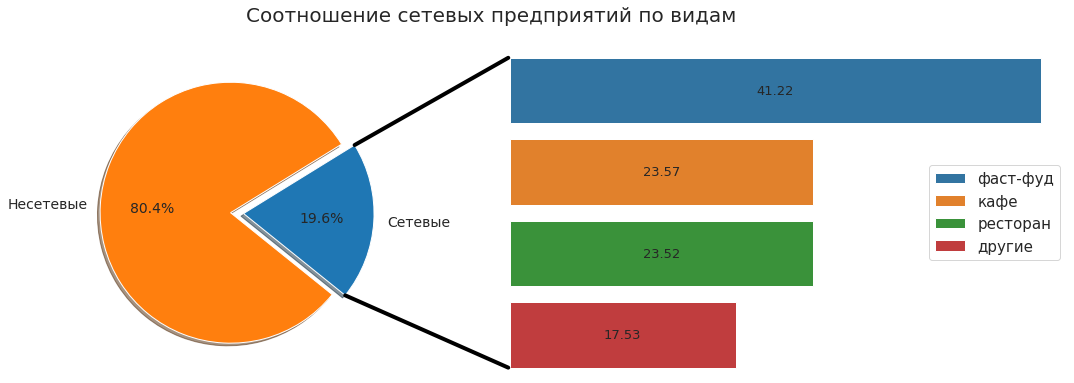

In [50]:
# строим график

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(wspace=0)

# круговая диаграмма

angle = -180 * (ch_ratio['id'].sum()/ch_ratio['id'][0]-1) + 5
values = lambda p: '{:.0f}'.format(p * ch_ratio['id'].sum() / 100)
wedges, *_ = ax1.pie(ch_ratio['id'], autopct='%1.1f%%', 
                     startangle=angle, shadow=True, textprops={'fontsize': 14},
                     labels=['Сетевые', 'Несетевые'], explode=[0.1, 0])

# линейчатая диаграмма

top_3 = top(3, 'chain_ratio')

sns.barplot(data=top_3, y='object_type',
            x='chain_ratio', hue='object_type', 
            ax=ax2, dodge=False
           )
for i in range(len(top_3)):
    ax2.bar_label(ax2.containers[i], size=13, label_type='center')

    
# соединяем графики

theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = 1
bottom = 1
width = .2

connect(-.4, theta2) # верхняя линия
connect(3.4, theta1) # нижняя линия

ax2.axis('off')
fig.suptitle('Соотношение сетевых предприятий по видам', size=20, va='top')

plt.legend(loc='right', prop={'size': 15})

plt.show()

- Сетевые предприятия составляют около 20% от всех заведений


- Несмотря на лидерство кафе по количеству сетевых заведений, предприятия быстрого обслуживания имеют самую значительную долю заведений, пренадлежащих к сети - 40%.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Отличные, интересные визуализации, можно было бы только их построение больше автоматизировать, уж очень схожи  </div>


<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо, очень старался! Я ограничился написанием функции для соединительных линий, но я согласен - можно пойти дальше. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Молодец!
</div>


<a id='EDA2'></a>

### Исследование соотношения количества посадочных мест в заведениях

На этом этапе будет исследовано соотношения количества заведений и их вместимость для сетевых предприятий, а также среднее количество посадочных мест для каждого вида заведения.

In [51]:
# сгруппируем данные по имени заведения

chain_capacity = (
    eda
    .pivot_table(index='object_name',
                 values='capacity',
                 aggfunc=('mean', 'count')
                )
    .reset_index()
    .rename(columns={'count':'object_count',
                     'mean':'mean_capacity'
                    })
)

# оставим только те сети, где больше двух заведений

chain_capacity = chain_capacity[chain_capacity['object_count'] > 2]

# используем функцию для категоризации вместимости
# расчитанной по квартилям основного датафрейма

chain_capacity['size'] = chain_capacity['mean_capacity'].apply(cap_category)

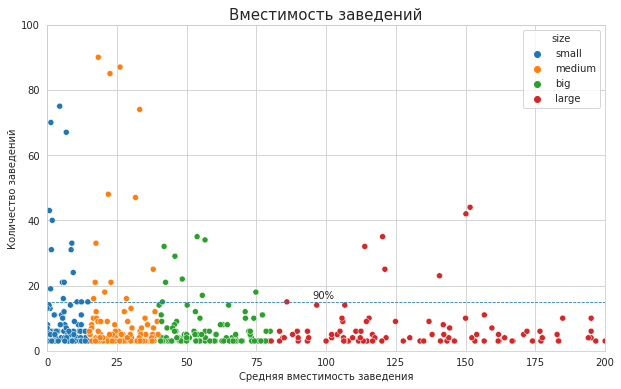


capacity/object count correlation


,object_count,mean_capacity
object_count,1.00,-0.07
mean_capacity,-0.07,1.00



object count per size


medium    123
big       119
small     117
large     114
Name: size, dtype: int64

In [52]:
# строим график

plt.figure(figsize=(10, 6))

sns.scatterplot(data = chain_capacity, 
                x='mean_capacity', 
                y='object_count',
                hue='size',
                hue_order = ['small', 'medium', 'big', 'large']
               )

plt.ylim(0, 100)
plt.xlim(0, 200)

plt.xlabel('Средняя вместимость заведения')
plt.ylabel('Количество заведений')
plt.title('Вместимость заведений')

plt.axhline(
    y=np.percentile(chain_capacity['object_count'], 90), 
    linestyle='--', linewidth= .8
)
plt.annotate('90%', xy=(95, 16))
plt.show()

# проверим наличие корреляции вместимости и количества объектов
# а также распределение категорий размера

print()
print('capacity/object count correlation')
display(chain_capacity.corr())
print()
print('object count per size')
display(chain_capacity['size'].value_counts())

In [53]:
np.percentile(chain_capacity['object_count'], 90)

15.0

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
* Отличная визуализация, можно было бы ещё нанести на график какие-то значения опорные - медиану, какой-нибудь перцентиль.
* Стоит ли учитывать сети, в которых одно заведений?)</div>


<div class="alert alert-info"> <b>Комментарий студента:</b> 
    
1. Спасибо, мне очень понравилась идея! По оси **y** медиана очень низкая, на графике не видно, добавил линию 90%. А по оси **x** значения у меня и так раскрашены по квартилям.
    
2. Я решил на этом этапе рассматривать сети с количеством заведений больше двух, чтобы нагляднее продемонстировать 'сетевой характер'. Но изначально перебирал разные варианты, и на самом деле соотношение особо не меняется при наличии сетей с одним заведением. 

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
По оси `x` действительно получилось разбиение по квартилям
</div>


- В целом соотношение размеров предприятий сопоставимо, с небольшим отрывом лидируют средние по вместимости заведения.


- Корреляция средней вместимости и количества предприятий в сети полностью отсутствует.

Теперь проанализируем количество посадочных мест по видам предприятий:

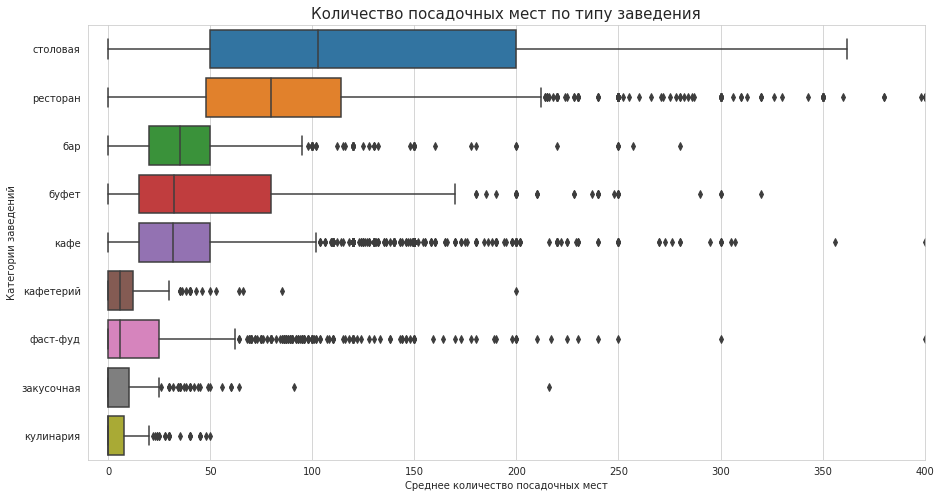

In [54]:
plt.figure(figsize=(15, 8))

order = (
    eda
    .groupby(by=["object_type"])["capacity"]
    .median()
    .sort_values(ascending=False)
    .index
)


sns.boxplot(x='capacity', y='object_type', 
            data=eda, order=order)

plt.title('Количество посадочных мест по типу заведения')
plt.xlim(-10, 400)
plt.xlabel('Среднее количество посадочных мест')
plt.ylabel('Категории заведений')

plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
`boxplot` самый лучший вариант для ответа на этот вопрос, а ещё и то, что ты ограничил ось, чтобы было нагляднее - превосходно вдвойне. Но может быть тебе будет интересно, как сделать твои `boxplot` ещё лучше, для этого можно обратиться к [этой статье](https://www.python-graph-gallery.com/39-hidden-data-under-boxplot) </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо большое, очень интересно! </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
На сайте ещё интересные всякие штуки про разные визуализации имеются, рекомендую 
</div>


- Столовые лидируют по количеству посадочных мест. Этот тип характерен не только высоким медианым значением, но и самым широким разбросом нормальных значений.

<a id='EDA3'></a>

### Исследование распределения заведений по локациям

В ходе предобработки данных нам удалось выделить из адресов заведений улицу, район и административный округ - составим топ-10 предприятий по каждому из этих параметров:

In [55]:
# функция для определения топа по локациям

def top_locations(area):
    
    top = (
        eda
        .pivot_table(index=area, 
                     values='id', aggfunc='count')
        .rename(columns={'id':'object_count'})    
        .sort_values('object_count', ascending=False)
        .reset_index()
    )
    
    return top

# выводим топ-10 улиц, с указанием района

top_10_streets = top_locations(('street', 'district'))[:10]

top_10_streets['street'] = (
    top_10_streets['street'] + ', ' + top_10_streets['district']
)
top_10_streets = top_10_streets.drop('district', axis=1)

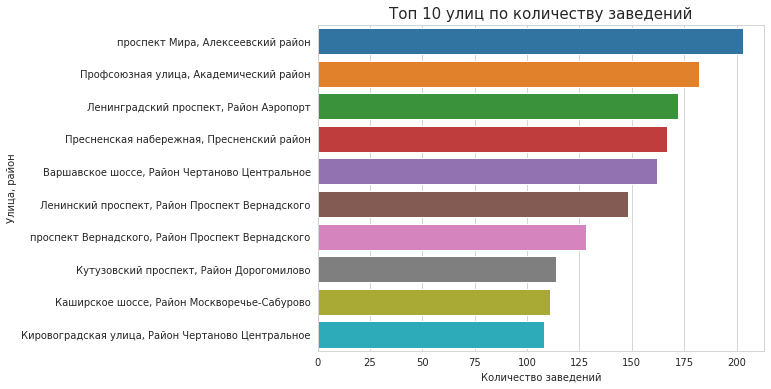

In [56]:
# визуализируем результат

plt.figure(figsize=(8, 6))

sns.barplot(data = top_10_streets, 
            x='object_count', y='street')


plt.xlabel('Количество заведений')
plt.ylabel('Улица, район')
plt.title('Топ 10 улиц по количеству заведений')


plt.show()

- Проспект Мира является лидирующей улицей по количеству заведений

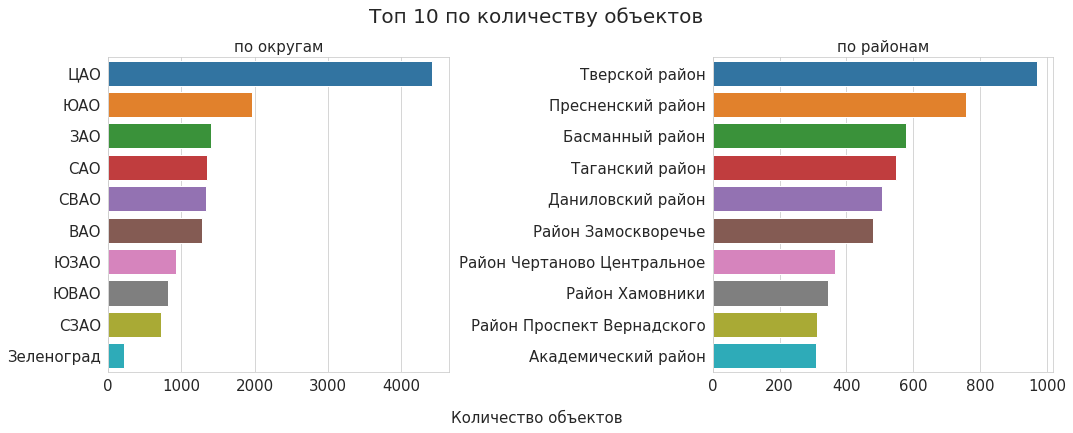

In [57]:
# визуализируем топ-10 по районам и административным округам

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

area_list = ['area', 'district']
axes = [ax1, ax2]
titles=['по округам', 'по районам', ]

for i in range(2):
    sns.barplot(data = top_locations(area_list[i])[:10], 
                x='object_count', y=area_list[i], ax=axes[i])
    
    axes[i].set(ylabel=None, xlabel=None, title=titles[i])
    axes[i].tick_params(labelsize=15)
    
fig.suptitle('Топ 10 по количеству объектов', size=20)
fig.supxlabel('Количество объектов', size=15)

plt.tight_layout()

plt.show()

- ЦАО лидирует по количеству предприятий с большим отрывом


- Самым популярным районом является Тверской район

Теперь исследуем конец списка - найдём количество улиц, на которых расположено одно заведение общественного питания:

Всего в данных представлено 122 уникальных района, 99 из них имеют улицы с 1 заведением.


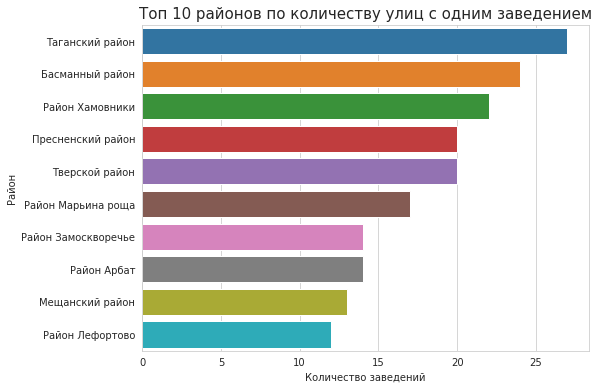

In [58]:
# группируем данные по районам

unpop_streets = (
    top_locations(['street', 'district'])
    .query('object_count == 1')
    .pivot_table(index='district', 
                 values = 'street', 
                 aggfunc='count')
    .sort_values('street', ascending=False)
    .reset_index()
)

# выводим 

print(f'Всего в данных представлено {len(data["district"].unique())} уникальных района, '
      f'{len(unpop_streets)} из них имеют улицы с 1 заведением.')

unpop_streets[:10]

# визуализируем топ-10 по количеству таких улицрезультат

plt.figure(figsize=(8, 6))

sns.barplot(data = unpop_streets[:10], 
            x='street', y='district')


plt.xlabel('Количество заведений')
plt.ylabel('Район')
plt.title('Топ 10 районов по количеству улиц с одним заведением')


plt.show()

- Список во многом совпадает с топом районов по количеству объектов, что говорит о том, что они имеют большой потенциал для успешного открытия новых предприятий.

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 

Если цвет не несет смысловой нагрузки, то делай все одним цветом. Иначе наш мозг думает, что в цвете есть какая-то логика и пытается ее отыскать
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Справедливо, спасибо! Учту на будущее. </div>

<a id='presentation'></a>

## Вывод

____
**Рекомендации**

- Такие районы Москвы, как Таганский, Пресненский и Тверской имеют большой потенциал - несмотря на то, что они лидируют по количеству предприятий общественного питания, они всё ещё имеют улицу с лишь одним заведением.

- Самыми оптимальным выбором типа заведения будут такие виды, как кафе, ресторан и предприятие быстрого обслуживания. Для сетевого развития больше подойдет "фаст-фуд", а при желание сделать заведение с большим количеством посадочных мест - ресторан подойдёт лучше всего. Кафе является компромисным вариантом по всем параметрам, чем скорее всего и обусловлена подавляющая популярность такого формата.

____

**Презентация**: https://drive.google.com/file/d/1mRzHjcboKld9qi2FuJNjyNFISD-UZNVU/view?usp=sharing
____

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    


Разумные рекомендации. Если интересно, то используя геокодер (или датасет с координитами для адресов) и геовизуализацию можно построить распределение кафе на территории Москвы и выделить интересующие нас районы, затем в этих районах можно отобразить доступные площащи для аренды, спарсив какой-нибудь сайт объявлений и таким образом выбрать нужное местоположение. https://geocoder.readthedocs.io/ + https://python-visualization.github.io/folium/quickstart.html. Этим можно заняться, если захочется вернуться к проекту
    
    
**Касательно презентации:** 
* Выводы в начале позволяют донести краткую выжимку, спасибо за них
* Понравилось, что есть описание данных + цели и задачи исследования, эти атрибуты задают отличный контекст работе
    
<br>
    
* Можно было бы добавить автора исследования
* Рекомендую добавить нумерацию слайдов, чтобы заказчики могли задать вопрос по твоей презентации не с "верните на вон тот слайд с ...", а просто по номеру слайда
* Рекомендую добавлять рамку для отделения графиков от остальной части презентации и их выравнивать от слайда к слайду, а сейчас при переключении есть ощущения, что графики всегда в разных местах


    

    
Для оформления презентаций могу порекомендовать сервис https://readymag.com/. 

</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Пётр, спасибо ещё раз большое за обратную связь, узнал много нового! 🔥 </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Было приятно с тобой поработать, желаю успехов!) 
</div>


Целью исследования являлось проведение исследовательского анализа рынка заведений общественного питания в Москве и подготовление презентации для потенциальных инвесторов, которые смогут использовать её для оценки инвестиционной привлекательности открытия нового ресторана.

**Ход исследования**

Для проекта были использованы открытые данные о заведениях общепита - адрес, количество посадочных мест, факт пренадлежности к какой-либо сети, а также тип предприятия по классификации заведений общественного питания в РФ <a href="https://docs.cntd.ru/document/1200107325">(**ГОСТ 30389-2013**)</a>. Данные были предобработаны и проанализированы, а на основании сделаных выводов была подготовлена презентация для инвесторов. Таким образом, исследование прошло в следующих этапах:

1. [**Обзор и предобработка данных**](#overview)

В ходе предобработки данных было удалено 4.48% датасета, при этом удалось сократить использование памяти на 23.33%. Большую часть данных удалось сохранить, а значительное сокращение используемых ресурсов памяти было достигнуто за счёт изменения типа данных, даже несмотря на формирование нескольких столбцов дополнительных данных.

Что было отмечено при работе с данными:

- Названия предприятий содержат множество неявных дубликатов, в основном обусловленных наличием опечаток или использованием разных регистров. В рамках исследования обработка названий заведений не оправдана - данных остальных столбцов будет достаточно для необходимых выводов.


- Некоторые улицы относятся одновременно к двум разным районам Москвы. В рамках исследования соотносить улицу с двумя районами технически невозможно, потому для каждой из них в случайном порядке был оставлен лишь одна локация - при формировании выводов необходимо будет сделать поправку на точность распределения заведений по районам.

2. [**Исследовательский анализ данных**](#EDA)

В ходе анализа были выполнены следующие шаги:

1. [**Исследования соотношения количества объектов общественного питания**](#EDA1)
2. [**Исследование соотношения количества посадочных мест в заведениях**](#EDA2)
3. [**Исследование распределения заведений по локациям**](#EDA3)

Общие выводы:

- Доля кафе составляет 40% от всех заведений. Вместе со столовыми, ресторанами, предприятиями быстрого питания и барами они составляют 90% всех предприятий Москвы.


- Сетевые предприятия составляют около 20% от всех заведений


- Кафе, рестораны и преприятия быстрого питания состовляют около 90% всех сетевых заведений.


- Несмотря на лидерство кафе по количеству сетевых заведений, предприятия быстрого обслуживания имеют самую значительную долю заведений, пренадлежащих к сети - 40%.


- В целом соотношение размеров предприятий сопоставимо, с небольшим отрывом лидируют средние по вместимости заведения.


- Корреляция средней вместимости и количества предприятий в сети полностью отсутствует.

- Столовые лидируют по количеству посадочных мест. Этот тип характерен не только высоким медианым значением, но и самым широким разбросом нормальных значений.

- Проспект Мира является лидирующей улицей по количеству заведений


- Округ ЦАО с большим отрывом лидирует по количеству предприятий 


- Самым популярным районом является Тверской район

- Всего в данных представлено 122 уникальных района, 99 из них имеют улицы с 1 заведением.

- Топ-10 районов по количеству улиц с одним заведением во многом совпадает с топом районов по количеству объектов, что может говорить о том, что они имеют большой потенциал для успешного открытия новых предприятий.